# **Packages**

In [ ]:
%pip install matplotlib
%pip install gensim==3.8.3
%pip install nltk
%pip install tensorboard
%pip install -U tensorboard_plugin_profile
%pip install vaderSentiment
%pip install tensorflow-gpu==2.9
%pip install tensorflow-text

In [ ]:
# Standard library
import os
import gzip
import gc
import datetime

# Data & computation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow
import tensorflow as tf
from tensorflow import keras
import tensorflow_text as tf_text

# Scikit-learn
from sklearn.model_selection import KFold

# Gensim
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as api
from gensim.summarization.summarizer import summarize
from gensim.summarization import keywords

# NLP (NLTK)
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

# Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Download required NLTK resources
nltk.download("punkt")

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
else :
  print("No GPU available")

# **Data Extraction**

In [15]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    name=b'"verified": \"true\",'
    l=l.replace(b'"verified": true,',bytes(name))
    name1=b'"verified": \"false\",'
    l=l.replace(b'"verified": false,',bytes(name))
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Grocery_and_Gourmet_Food_5.json.gz')

# dataset link
# Grocery and Gourmet Food
# https://jmcauley.ucsd.edu/data/amazon/

Dataset Schema

In [16]:
df.rename(columns={"reviewerID": "userID", "asin": "itemID","overall":"rating"},inplace=True)
df=df[['userID','itemID','reviewText','rating']]
df

,userID,itemID,reviewText,rating
0,A1VEELTKS8NLZB,616719923X,Just another flavor of Kit Kat but the taste i...,4.0
1,A14R9XMZVJ6INB,616719923X,I bought this on impulse and it comes from Jap...,3.0
2,A27IQHDZFQFNGG,616719923X,Really good. Great gift for any fan of green t...,4.0
3,A31QY5TASILE89,616719923X,"I had never had it before, was curious to see ...",5.0
4,A2LWK003FFMCI5,616719923X,I've been looking forward to trying these afte...,4.0
...,...,...,...,...
151249,A2L6QS8SVHT9RG,B00KCJRVO2,Delicious gluten-free oatmeal: we tried both t...,4.0
151250,AFJFXN42RZ3G2,B00KCJRVO2,With the many selections of instant oatmeal ce...,4.0
151251,ASEBX8TBYWQWA,B00KCJRVO2,"While I usually review CDs and DVDs, as well a...",5.0
151252,ANKQGTXHREOI5,B00KCJRVO2,My son and I enjoyed these oatmeal packets. H...,4.0


# **Data Analysis**

**User Data**

determining all unique users with their reviews and ratings

In [17]:
user_df=df[['userID','reviewText',"itemID"]].groupby('userID')['reviewText','itemID'].apply(lambda x: pd.Series([list(x['reviewText']),list(x['itemID'])],index=['reviewText', 'itemID'])).reset_index()
user_df

/home/mobin/anaconda3/envs/colabenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,userID,reviewText,itemID
0,A00177463W0XWB16A9O05,[It is a good stand by coffee you can count on...,"[B0029XDZIK, B003C4YIFE, B003YUW7EK, B00474OR8..."
1,A022899328A0QROR32DCT,[awesome texture for even the gluten eating ea...,"[B000EVE3Y4, B001ACMCNU, B003TO9RSU, B003V8QGA..."
2,A04309042SDSL8YX2HRR7,[I love roasted garlic & sweet bell peppers. Y...,"[B000B6J51I, B000EM6Q34, B000FYXBPW, B003VN74V..."
3,A068255029AHTHDXZURNU,[These bars are especially delicious for cocon...,"[B000HKFF94, B000K8WVYA, B001FA1K2G, B00474VPY..."
4,A06944662TFWOKKV4GJKX,[UGH! My stomach has been really killing me l...,"[B000CMD63E, B000CQBZPG, B000GFYRHG, B000GZYAR..."
...,...,...,...
14676,AZWRZZAMX90VT,"[Very nice. Not spicy, not too salty, lots of ...","[B0007R9L4M, B0007R9L5Q, B000CN7BMA, B000CQ01G..."
14677,AZXKAH2DE6C8A,[Could not imagine having such a rich tasting ...,"[B0004N14BC, B0005XOVY8, B000EML7DS, B000EOXQR..."
14678,AZXON596A1VXC,[I was a bit skeptical when I bought this prod...,"[B00113SKZW, B00113ZTVK, B001EO5RCM, B001EO5S0..."
14679,AZYXC63SS008M,[This is just about the healthiest you can get...,"[B000NGNEKY, B0039LVLS2, B0040QCJDG, B0040WCQK..."


**Item Data**

determining all unique items with their reviews and ratings

In [18]:
item_df=df[['itemID','reviewText','userID']].groupby('itemID')['reviewText','userID'].apply(lambda x: pd.Series([list(x['reviewText']),list(x['userID'])],index=['reviewText', 'userID'])).reset_index()
item_df

/home/mobin/anaconda3/envs/colabenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,itemID,reviewText,userID
0,616719923X,[Just another flavor of Kit Kat but the taste ...,"[A1VEELTKS8NLZB, A14R9XMZVJ6INB, A27IQHDZFQFNG..."
1,9742356831,[This curry paste makes a delicious curry. I ...,"[A23RYWDS884TUL, A945RBQWGZXCK, A1TCSC0YWT82Q0..."
2,B00004S1C5,[These dyes create awesome colors for kids cra...,"[A1C8NAHYR6Z10F, A14YSMLYLJEMET, A1358PQON9ZAK..."
3,B0000531B7,[I really enjoy these bars as a quick breakfas...,"[ATN5X2PM7OB3K, A2BYV7S1QP2YIG, A2TN9C5E4A0I3F..."
4,B00005344V,"[Traditional Medicinals' ""Breathe Easy"" is an ...","[A3EBHHCZO6V2A4, A1P9UMP1XSE6MI, A2F488C4PLWGE..."
...,...,...,...
8708,B00JGPG60I,[We switched to this formula 5 days ago and fo...,"[A2D7X9N3IV3S7B, A36NUDST4Y5JBA, A2E4R7YISIM4Q..."
8709,B00JL6LTMW,[We have enjoyed Larabar's variety of bars for...,"[A1QR76SYGTXJN5, A1P2XYD265YE21, A1P9BVW2JB1OV..."
8710,B00K00H9I6,[This 100% pure Canadian maple syrup is a Grad...,"[A23GFTVIETX7DS, A35W3JQYP0M655, A1UQBFCERIP7V..."
8711,B00KC0LGI8,[I followed the directions on the box exactly ...,"[A34U4Y40W1GW9I, A1P9BVW2JB1OVL, A3DS0VAXL90E2..."


In [19]:
print("review num : ", df.shape[0] ,"user num : " ,user_df.shape[0],"item num : ",item_df.shape[0] )

review num :  151254 user num :  14681 item num :  8713


##   Ratings

count    151254.000000
mean          4.243042
std           1.090003
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

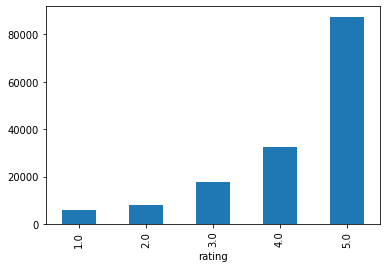

In [20]:
df.groupby('rating').size().plot(kind="bar");
df['rating'].describe()
#histogram of ratings

## Reviews

In [21]:
df['reviewText'].describe()

count     151254
unique    151199
top             
freq          22
Name: reviewText, dtype: object

count    151254.000000
mean        509.002142
std         524.745639
min           0.000000
25%         191.000000
50%         353.000000
75%         644.000000
max       29569.000000
Name: reviewText, dtype: float64

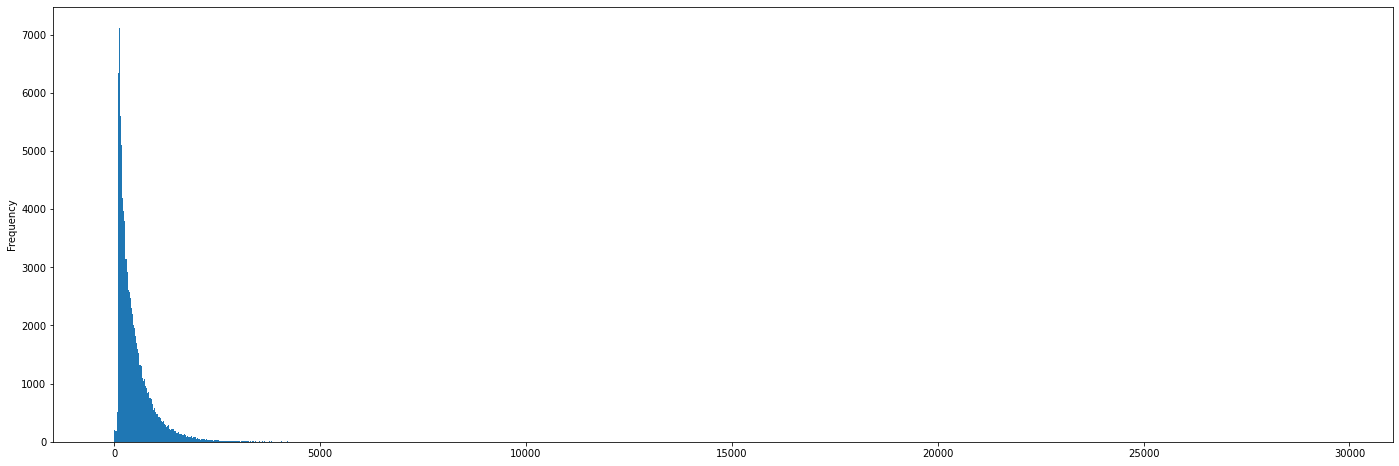

In [22]:
# review length
rv_le=df['reviewText'].apply(lambda x:len(x) )
rv_le.plot(kind='hist',bins=2000,figsize=(24, 8),xlabel="length of reviews")
rv_le.describe()


In [23]:
sum=0
sum2=0
for x in user_df['reviewText']:
  sum+=len(x)
  for y in x:
   sum2 +=len(y)

r_mean=sum/len(user_df['reviewText'])
w_mean=sum2/(r_mean*len(user_df['reviewText']))
print('mean of reviews per user:', r_mean)
print('mean of words per review:', w_mean)
print('mean of words per user:',r_mean * w_mean)
# plot for reviews per user

mean of reviews per user: 10.302704175464887
mean of words per review: 509.00214209211
mean of words per user: 5244.098494652953


count    8713.000000
mean       17.359578
std        33.915980
min         5.000000
25%         6.000000
50%         8.000000
75%        14.000000
max       742.000000
Name: reviewText, dtype: float64

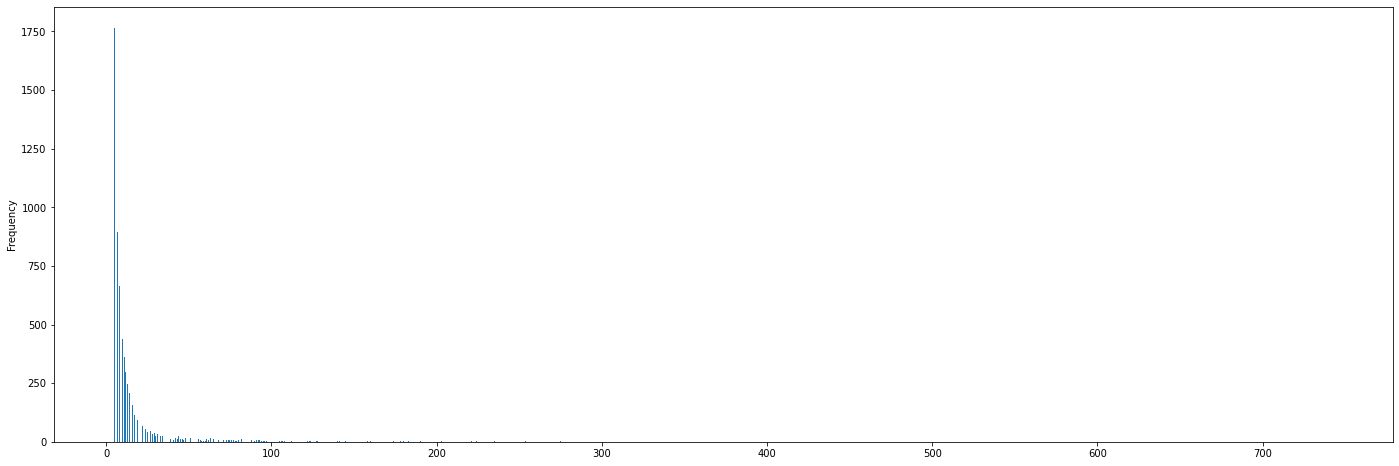

In [24]:
rv_le=item_df['reviewText'].apply(lambda x:len(x) )
rv_le.plot(kind='hist',bins=2000,figsize=(24, 8),xlabel="length of reviews")
rv_le.describe()

count    14681.000000
mean        10.302704
std         10.581392
min          5.000000
25%          5.000000
50%          7.000000
75%         11.000000
max        204.000000
Name: reviewText, dtype: float64

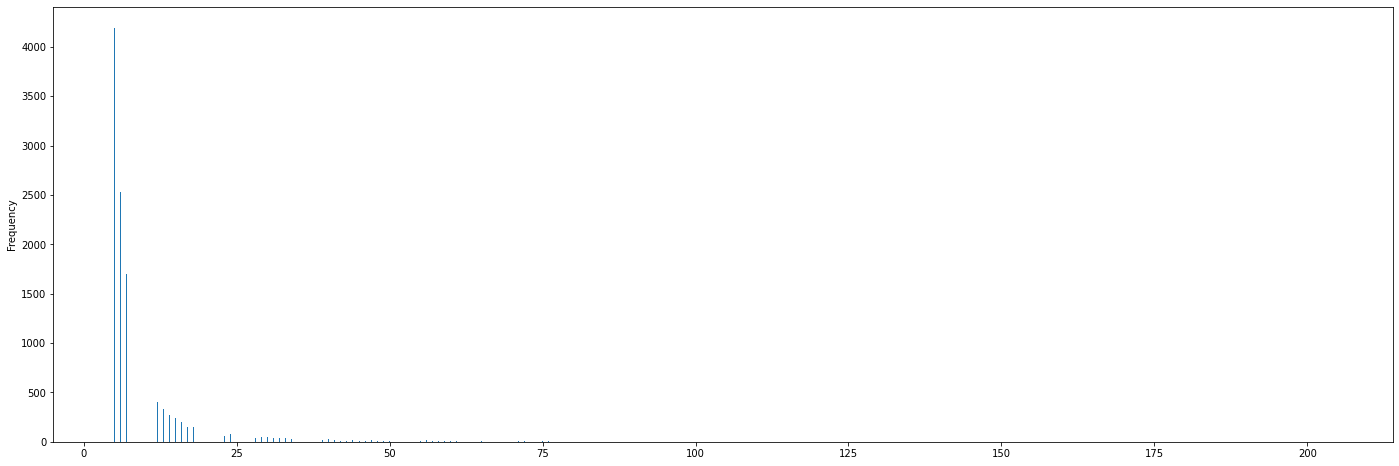

In [25]:
rv_le=user_df['reviewText'].apply(lambda x:len(x) )
rv_le.plot(kind='hist',bins=2000,figsize=(24, 8),xlabel="length of reviews")
rv_le.describe()

In [26]:
sum=0
sum2=0
for x in item_df['reviewText']:
  sum+=len(x)
  for y in x:
   sum2 +=len(y)

r_mean=sum/len(item_df['reviewText'])
w_mean=sum2/(r_mean*len(item_df['reviewText']))
print('mean of reviews per item:', r_mean)
print('mean of words per review:', w_mean)
print('mean of words per item:',r_mean * w_mean)

mean of reviews per item: 17.359577642603007
mean of words per review: 509.00214209211
mean of words per item: 8836.062205899232


# **Data Splitting**

In [27]:
if os.path.exists("train_df.csv") & os.path.exists("test_df.csv"):
        train_df = pd.read_csv('train_df.csv')
        test_df = pd.read_csv('test_df.csv')

else:
    current_fold=10
    kfold = KFold(10)
    random_iterator=kfold.split(df)
    for i in range(current_fold):
      train_index, test_index = next(random_iterator, None)
      print(train_index,len(train_index))
      train_df, test_df =df.iloc[train_index], df.iloc[test_index]
    train_df.to_csv('train_df.csv')
    test_df.to_csv('test_df.csv')
    

In [28]:
train_df

,Unnamed: 0,userID,itemID,reviewText,rating
0,0,A1VEELTKS8NLZB,616719923X,Just another flavor of Kit Kat but the taste i...,4.0
1,1,A14R9XMZVJ6INB,616719923X,I bought this on impulse and it comes from Jap...,3.0
2,2,A27IQHDZFQFNGG,616719923X,Really good. Great gift for any fan of green t...,4.0
3,3,A31QY5TASILE89,616719923X,"I had never had it before, was curious to see ...",5.0
4,4,A2LWK003FFMCI5,616719923X,I've been looking forward to trying these afte...,4.0
...,...,...,...,...,...
136124,136124,A74CGCGJ11Y23,B009M516NE,I've made rice pilaf from scratch. I've also t...,4.0
136125,136125,A36MP37DITBU6F,B009M516NE,This is a slightly mild flavored rice pilaf. t...,4.0
136126,136126,A1JBBR4MNGQ70G,B009M516NE,I added a package of Albacore tuna to this mix...,3.0
136127,136127,A2P739KOM4U5JB,B009M516NE,I am happy to report that Side Mates were grea...,4.0


# **Embedding Matrix**

In [29]:
# hyperparameters
embedding_dim=300
min_frequent_word_num=5
max_vocab_size=30000
sequence_length=250
document_length=40

In [30]:
def tf_lower_and_split_punct(text):
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  text = tf.strings.strip(text)
  text= tf.strings.reduce_join( tf.strings.split(text)[:,:sequence_length-2],axis=-1,separator=' ')
  return  text.numpy()

In [31]:
with tf.device('/CPU:0'):
    user_corpus =list(map(tf_lower_and_split_punct,user_df['reviewText'])) 


In [32]:
def load_word2vec_model():
    if os.path.exists("word2vec.wordvectors"):
        print("loaded from word2vec.wordvectors")
        return KeyedVectors.load("word2vec.wordvectors",mmap='r')
    else:
        # downloading google news word2vec model
        if not os.path.exists("word2vec_google.bin"):
            downloaded_model = api.load('word2vec-google-news-300')
            downloaded_model.save_word2vec_format('word2vec_google.bin',binary=True)
            del downloaded_model
        # loading google news word2vec model
        google_word2vec = KeyedVectors.load_word2vec_format("word2vec_google.bin", binary=True)

       # tokenizing the whole reviews in text_corpus
        text_corpus=[]
        for i,doc in enumerate(user_corpus):    # iterate through each sentence in the reviews
            for rv in doc:
                for sen in sent_tokenize(rv.decode("utf-8")):
                    temp = []
                    # tokenize the sentence into words          
                    for j in word_tokenize(sen):
                        temp.append(j.lower())
                    text_corpus.append(temp)
                    del temp


        # creating a new word2vec model and initializing it from pretrained google_word2vec
        word2vec_model=Word2Vec( text_corpus,max_final_vocab=max_vocab_size,min_count=min_frequent_word_num ,vector_size= embedding_dim,window = 5,workers=16, sg=1,epochs=1)
        word2vec_model.build_vocab(text_corpus)

        word2vec_model.build_vocab([google_word2vec.index_to_key],update=True)
        word2vec_model.wv.vectors_lockf = np.ones(len(word2vec_model.wv))
        word2vec_model.wv.intersect_word2vec_format("word2vec_google.bin",binary=True,lockf=1.0)
        
        # fine tuning the model and saving it
        word2vec_model.train(text_corpus, epochs=5, total_examples=word2vec_model.corpus_count)
        word2vec_model.wv.save("word2vec.wordvectors")
        
        del google_word2vec
        del text_corpus[:]
        gc.collect()
  
        return word2vec_model.wv
        

In [33]:
# loading the embedding lookup matrix shape=( 30k ,300 ) approximately
embedding_matrix = load_word2vec_model() 
print( "embedding matrix shape : (",len(embedding_matrix.index_to_key)," ,",embedding_matrix.vector_size,")")

loaded from word2vec.wordvectors
embedding matrix shape : ( 22284  , 300 )


In [34]:
# adding 4 vectors for start end unknow and null tokens
special_token_embedding = np.random.rand(4,embedding_matrix.vector_size)
full_embedding_matrix = np.concatenate((special_token_embedding,embedding_matrix.vectors))
full_embedding_matrix.shape

(22288, 300)

In [35]:
# example
# embedding_matrix['keep']

# **Text Vectorization**

In [36]:
# hyperparameter

batch_size = 16 # for encoder model
batch_size_test = 32 # for encoder model
num_batches = int(train_df.shape[0]/batch_size)
num_batches_test = int(test_df.shape[0]/batch_size_test)
print("number of batches in train data",num_batches)
print("number of batches in test data",num_batches_test)

number of batches in train data 8508
number of batches in test data 472


## **Preprocessing**

In [37]:
def tf_lower_and_split_punct_enc(text):
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  text = tf.strings.strip(text)
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text


## Vectorization layer

- The conversion of tokens to ids

In [38]:
enc_input_processor = tf.keras.layers.TextVectorization( max_tokens = max_vocab_size,
                                                     standardize = tf_lower_and_split_punct_enc,
                                                     output_sequence_length = sequence_length,  )

In [39]:
enc_input_processor.set_vocabulary(['','[UNK]','[START]','[END]'] +  embedding_matrix.index_to_key )

In [41]:
# example
print(item_df['reviewText'][1000])
print(enc_input_processor(  item_df['reviewText'][1000]))

["These candies are very good. They have a nice cherry flavor with just a little bit of sour thrown in. Most sour candies made these days make your eyes water and your mouth pucker. Not these gummi's, they have just enough of a sour taste to make them interesting but the sour taste is very very mild.My order came in great condition and very fresh.", 'Decided to try these out since I loved the non sour versions of this gummy. Great in their own right but I have to say that the originals are the best. But these have a very unique taste. And not really that sour, just a little bitterness to them but nothing to take away from the over all taste.', 'received very fast and item  was in tact. If for personal use over a long period suggest divide it up and put into airtight storage bags or a sealer to keep soft and tasty!', "These Haribo sour cherries are vibrantly colored and look like a red cherry on a green stem with a green leaf attached.  Each piece is over an inch long.  They are very cu

# **Forming Dataset**

In [42]:
# convert string id to int id
user_to_row = {}
item_to_column = {}

for i, user_id in enumerate(np.unique(df['userID'])):
    user_to_row[user_id] = i

for j, item_id in enumerate(np.unique(df['itemID'].tolist())):
    item_to_column[item_id] = j

In [43]:
item_df["userID"]=item_df["userID"].apply(lambda x :[user_to_row[el] for el in x ])
user_df["itemID"]=user_df["itemID"].apply(lambda x :[item_to_column[el] for el in x ])

In [44]:
train_ds_seq = tf.data.Dataset.from_tensor_slices(
    (
       [user_to_row[dp] for dp in train_df['userID']],
       [item_to_column[dp] for dp in train_df['itemID']]
     
    )
).shuffle(131072).batch(batch_size,drop_remainder=True)

test_ds_seq = tf.data.Dataset.from_tensor_slices(
    (
       [user_to_row[dp] for dp in test_df['userID']],
       [item_to_column[dp] for dp in test_df['itemID']]
     
    )
).shuffle(16384).batch(batch_size,drop_remainder=True)


train_ds_pmf = tf.data.Dataset.from_tensor_slices(
    (
       [user_to_row[dp] for dp in train_df['userID']],
       [item_to_column[dp] for dp in train_df['itemID']],
       tf.cast(train_df['rating'],dtype=tf.float16)
    )
).shuffle(131072).batch(1024)
test_ds_pmf = tf.data.Dataset.from_tensor_slices(
    (
      [user_to_row[dp] for dp in test_df['userID']],
      [item_to_column[dp] for dp in test_df['itemID']],
      tf.cast(test_df['rating'],dtype=tf.float16)
    )
).shuffle(16384).batch(256)

In [45]:
train_data_num=train_df.shape[0]
test_data_num=test_df.shape[0]
print("train and test data number : ",train_data_num," , ",test_data_num)

train and test data number :  136129  ,  15125


# **User and Item Documents**

**User Documents**

In [46]:
user_doc = list( map(enc_input_processor,[doc[:document_length] for doc in user_df['reviewText']]))

**Item Documents**

In [47]:
item_doc = list( map(enc_input_processor,[doc[:document_length] for doc in item_df['reviewText']]))

# **Metrics**

In [48]:
# log files for training and test
train_log_dir = 'logs/'  + '/train'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_log_dir = 'logs/'  + '/test'
test_summary_writer = tf.summary.create_file_writer(test_log_dir)
graph_log_dir = 'logs/graph/'  
graph_summary_writer = tf.summary.create_file_writer(graph_log_dir)

In [49]:
class RegularizationLoss(tf.keras.metrics.Metric):
    def __init__(self,name='perplexity',**kwargs):
        super().__init__(name=name, **kwargs)
        self.regularizationloss=self.add_weight(name='rg',initializer='zeros')

    def update_state(self, loss):
        self.regularizationloss= loss

    def result(self):
        return self.regularizationloss


class MSE(tf.keras.metrics.Metric):
    def __init__(self,name='MSE',**kwargs):
        super().__init__(name=name, **kwargs)
        self.mse=self.add_weight(name='mse',initializer='zeros')

    def update_state(self,mse):
        self.mse =  mse

    def result(self):
        return self.mse


In [50]:
# metrics
train_reg_loss = RegularizationLoss(name="reg")
train_mse = MSE(name='trian mse')
test_mse = MSE(name='test mse')

# **Context-aware Matrix Factorization for Rating Prediction**

In [51]:
#hyperparameters
num_users=len(user_to_row)
num_items=len(item_to_column)
mean_inv = np.float32( train_df['rating'].mean())
feature_num=128 # number of topics
units=int(feature_num/2 )# gru units

## **PMF (Probabilistic Matrix Factorization)**

In [52]:
class PMF():
    def __init__(self, num_feat=16, epsilon=1, _lambda=0.2, momentum=0.8,  batch_size=1024,num_item=9000,num_user=15000,mean_inv=3.00000):
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.num_item=num_item
        self.num_user=num_user
        self.V =  0.1 * np.random.randn(self.num_item, self.num_feat).astype(np.float64)  # Item feature vectors
        self.U =  0.1 * np.random.randn(self.num_user, self.num_feat).astype(np.float64)  # User feature vectors
        self.V_inc = np.zeros((self.num_item, self.num_feat),dtype=np.float64)
        self.U_inc = np.zeros((self.num_user, self.num_feat),dtype=np.float64)
        self.mean_inv= mean_inv  
        
        self.user_textual_features = np.zeros(shape=(num_users, feature_num),dtype=np.float32 )
        self.item_textual_features =  np.zeros(shape=(num_items, feature_num),dtype=np.float32)
        self.user_recommender_features =  np.zeros(shape=(num_users, feature_num),dtype=np.float64)
        self.item_recommender_features =  np.zeros(shape=(num_items, feature_num),dtype=np.float64)
    
    def update_textual_features(self, user_textual_features , item_textual_features ):
        self.user_textual_features = user_textual_features
        self.item_textual_features = item_textual_features 



    def train(self):
            
            for batch_UserID,batch_ItemID, batch_rating  in train_ds_pmf:
                  
                # Compute Objective Function             
                pred_out = np.sum(np.multiply(self.U[batch_UserID, :],
                                              self.V[batch_ItemID, :]),
                                  axis=1)  # mean_inv subtracted # np.multiply
                
                rawErr = pred_out - batch_rating.numpy() + self.mean_inv

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.V[batch_ItemID, :]) \
                       + self._lambda * (self.U[batch_UserID, :] - self.user_textual_features[batch_UserID,:] )
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.U[batch_UserID, :]) \
                       + self._lambda * (self.V[batch_ItemID, :] - self.item_textual_features[batch_ItemID,:] ) 
                       # np.newaxis :increase the dimension
               
                dw_Item = np.zeros((self.num_item, self.num_feat))
                dw_User = np.zeros((self.num_user, self.num_feat))
                
                # loop to aggreate the gradients of the same element
                for i in range(batch_UserID.shape[0]):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
              
                self.V_inc = self.momentum * self.V_inc + self.epsilon * dw_Item / self.batch_size
                self.U_inc = self.momentum * self.U_inc + self.epsilon * dw_User / self.batch_size
                
                self.V = self.V - self.V_inc
                self.U = self.U - self.U_inc
            
                # Compute Objective Function after
            self.evaluate()

            return  tf.Variable(self.U) , tf.Variable(self.V)
    
    def evaluate(self):
            rawErr= []
            for batch_UserID,batch_ItemID, batch_rating  in train_ds_pmf:
                        
                pred_out = np.sum(np.multiply(self.U[batch_UserID, :],
                                        self.V[batch_ItemID, :]),
                                axis=1)  # mean_inv subtracted
                rawErr.append(pred_out - batch_rating.numpy() + self.mean_inv)

            obj = np.linalg.norm([item for sublist in rawErr for item in sublist]) ** 2 
                   # + 0.5 * self._lambda * (np.linalg.norm(self.U - self.user_textual_features) ** 2 + np.linalg.norm(self.V - self.item_textual_features) ** 2)

            train_mse.update_state(obj / train_data_num)
           # Compute test error
            rawErr= []
            for batch_UserID,batch_ItemID, batch_rating  in test_ds_pmf:
                pred_out = np.sum(np.multiply(self.U[batch_UserID, :],
                                        self.V[batch_ItemID, :]),
                                axis=1)  # mean_inv subtracted

                rawErr.append(pred_out - batch_rating.numpy() + self.mean_inv)

            test_mse.update_state(np.linalg.norm([item for sublist in rawErr for item in sublist])**2 / test_data_num)
            # Print info
            print('\nTraining mse: %f, Test mse %f' % (train_mse.result(), test_mse.result()))


    def predict(self, invID):
        return np.dot(self.V, self.U[int(invID), :]) + self.mean_inv  

    def topK(self, user_number, k=10):
        inv_lst = np.random.choice(range(0,self.num_user),user_number).astype('int32')
        pred = {}
        for inv in inv_lst:
            if pred.get(inv, None) is None:
                pred[inv] = np.argsort(self.predict(inv))[-k:]  
  
        for _,user_id in enumerate(pred):
           print("user id:",user_id,"recommended items",pred[user_id])
        return pred

# **Encoder**

In [53]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self,vocab_size, embedding_dim, enc_units):
    super().__init__()
    self.enc_units = enc_units
    self.embedding_dim=embedding_dim
    self.vocab_size = vocab_size
    
    self.embedding = tf.keras.layers.Embedding( self.vocab_size, self.embedding_dim, embeddings_initializer=keras.initializers.Constant(full_embedding_matrix),trainable=False)
    self.gru= tf.keras.layers.Bidirectional(tf.keras.layers.GRU(  self.enc_units,return_state=True,  recurrent_initializer='glorot_uniform' ))


  def call(self, reviews, state=None):
    vectors = self.embedding(reviews)
    _,encoder_forward_state,encoder_backward_state  = self.gru(vectors, initial_state=state)
 
    return  tf.concat([ encoder_forward_state, encoder_backward_state],-1)

    

# **Topic Model**

In [54]:
class Seq2Seq(tf.keras.Model): 
    def __init__(self,num_topic,num_item ,num_user, units ,embedding_dim,vocab_size ,sequence_length, num_batches,num_batches_test, batch_size, use_tf_function=False):
        super().__init__()
        self.num_batches_test = num_batches_test
        self.num_batches = num_batches # train batch number
        self.batch_size = batch_size
        self.num_topic = num_topic
        self.embedding_dim = embedding_dim
        self.units = units
        self.vocab_size = vocab_size
        self.sequence_length = sequence_length
        self.num_item = num_item
        self.num_user = num_user
        self.alpha = 10.0
        self.user_encoder = Encoder(vocab_size= self.vocab_size,  embedding_dim= self.embedding_dim, enc_units= self.units)
        self.item_encoder = Encoder(vocab_size= self.vocab_size,  embedding_dim= self.embedding_dim, enc_units= self.units)     
        self.optimizer_gn = tf.optimizers.Adam(1e-4)

        self.user_textual_features = np.zeros(shape=(num_users, feature_num),dtype=np.float32 )
        self.item_textual_features =  np.zeros(shape=(num_items, feature_num),dtype=np.float32)
        self.user_recommender_features =  np.zeros(shape=(num_users, feature_num),dtype=np.float64)
        self.item_recommender_features =  np.zeros(shape=(num_items, feature_num),dtype=np.float64)

    
    
    def update_recommender_features(self,user_recommender_features , item_recommender_features):
         self.user_recommender_features = user_recommender_features
         self.item_recommender_features = item_recommender_features

    def generate_textual_features(self):
          for start_index in range(0, self.num_user, self.batch_size):
            end_index = min(start_index + self.batch_size, self.num_user)                           
            batch_userID = np.arange(start_index, end_index)

            # fetch a batch of user doc
            batch_userdoc_flattend=[]
            userdoc_slice_idx=[0]
            for doc_id in batch_userID:
              userdoc_slice_idx.append(userdoc_slice_idx[-1] + user_doc[doc_id].shape[0])
              batch_userdoc_flattend = np.append(batch_userdoc_flattend,user_doc[doc_id])
            batch_userdoc = tf.reshape(tf.convert_to_tensor( batch_userdoc_flattend,dtype=tf.int32),[userdoc_slice_idx[-1],self.sequence_length])

            user_enc_state = self.user_encoder(batch_userdoc) # user vector representations      
            user_context_vector = tf.stack([ tf.reduce_mean(user_enc_state[ userdoc_slice_idx[sl_num] : userdoc_slice_idx[sl_num+1] ],0) for  sl_num in range(len(batch_userID))])
            
            self.user_textual_features[batch_userID]=user_context_vector.numpy()
            
          for start_index in range(0, self.num_item, self.batch_size):
            end_index = min(start_index + self.batch_size, self.num_item)                           
            batch_itemID = np.arange(start_index, end_index)

            # fetch a batch of item doc
            batch_itemdoc_flattend=[]
            itemdoc_slice_idx=[0]
            for doc_id in batch_itemID:
              itemdoc_slice_idx.append(itemdoc_slice_idx[-1] + item_doc[doc_id].shape[0])
              batch_itemdoc_flattend = np.append(batch_itemdoc_flattend,item_doc[doc_id])
            batch_itemdoc = tf.reshape(tf.convert_to_tensor( batch_itemdoc_flattend,dtype=tf.int32),[itemdoc_slice_idx[-1],self.sequence_length])
            
            item_enc_state = self.item_encoder(batch_itemdoc) # item vector representations
            item_context_vector = tf.stack([ tf.reduce_mean(item_enc_state[ itemdoc_slice_idx[sl_num] : itemdoc_slice_idx[sl_num+1] ],0) for  sl_num in range(len(batch_itemID))])
            
            self.item_textual_features[batch_itemID]=item_context_vector.numpy()
           
            return tf.Variable(self.user_textual_features) , tf.Variable(self.item_textual_features)

    def train(self):
          total_gen_loss=0
          for t_step in range(self.num_batches):
 
            (batch_userID,batch_itemID) = next(iter(train_ds_seq))
            # fetch a batch of user doc
            batch_userdoc_flattend=[]
            userdoc_slice_idx=[0]
            for doc_id in batch_userID:
              userdoc_slice_idx.append(userdoc_slice_idx[-1] + user_doc[doc_id].shape[0])
              batch_userdoc_flattend = np.append(batch_userdoc_flattend,user_doc[doc_id])
            batch_userdoc = tf.reshape(tf.convert_to_tensor( batch_userdoc_flattend,dtype=tf.int32),[userdoc_slice_idx[-1],self.sequence_length])

            # fetch a batch of item doc
            batch_itemdoc_flattend=[]
            itemdoc_slice_idx=[0]
            for doc_id in batch_itemID:
              itemdoc_slice_idx.append(itemdoc_slice_idx[-1] + item_doc[doc_id].shape[0])
              batch_itemdoc_flattend = np.append(batch_itemdoc_flattend,item_doc[doc_id])
            batch_itemdoc = tf.reshape(tf.convert_to_tensor( batch_itemdoc_flattend,dtype=tf.int32),[itemdoc_slice_idx[-1],self.sequence_length])
            
            with tf.GradientTape() as tape :              
              user_enc_state = self.user_encoder(batch_userdoc) # user vector representations      
              item_enc_state = self.item_encoder(batch_itemdoc) # item vector representations
              
              user_context_vector = tf.stack([ tf.reduce_mean(user_enc_state[ userdoc_slice_idx[sl_num] : userdoc_slice_idx[sl_num+1] ],0) for  sl_num in range(self.batch_size)])
              item_context_vector = tf.stack([ tf.reduce_mean(item_enc_state[ itemdoc_slice_idx[sl_num] : itemdoc_slice_idx[sl_num+1] ],0) for  sl_num in range(self.batch_size)])

              # regularization 
              user_regularization_loss = self.alpha * tf.norm(self.user_recommender_features[batch_userID.numpy()] - user_context_vector) **2
              item_regularization_loss = self.alpha * tf.norm(self.item_recommender_features[batch_itemID.numpy()] - item_context_vector) **2
              regularization_loss = user_regularization_loss + item_regularization_loss
            grad_enc = tape.gradient(regularization_loss,self.user_encoder.trainable_variables + self.item_encoder.trainable_variables)
            self.optimizer_gn.apply_gradients(zip( grad_enc, self.user_encoder.trainable_variables + self.item_encoder.trainable_variables ))            
            
            total_gen_loss += regularization_loss
            # total_regularization_loss += regularization_loss
            if t_step % 10 == 0:
              print("batch number: ",t_step,"\t encoding loss: ", regularization_loss.numpy())
    
          train_reg_loss.update_state(total_gen_loss / self.num_batches)

    def test(self,num_steps):
        total_loss=0
        for step in range(num_steps):
            #(batch_userID,batch_itemID ,_,_) = next(iter(test_ds_seq))
            batch_userID = np.random.choice(range(0,self.num_user),self.batch_size).astype('int32')
            batch_itemID = np.random.choice(range(0,self.num_item),self.batch_size).astype('int32') 
            context_vector = tf.concat([self.user_textual_features[batch_userID],self.item_textual_features[batch_itemID]],1)                    
            predicted_samples,dec_prob = self.generate_sample(context_vector)
            loss = self.loss_gn(predicted_samples ,tf.transpose( tf.stack(dec_prob), [1,0,2])  )
            total_loss += loss
            if step % 4 == 0:
              print("batch number: ",step, "\tgen loss: ",loss.numpy())

        test_plx_gen.update_state(total_loss / num_steps)
  
  

 

# **Ploting Results**

In [55]:
%load_ext tensorboard

In [56]:
%tensorboard --logdir logs --bind_all
# deactive tracking protection of the page if you get 403 error


# **Multi-Task Learning**

In [57]:
class MultiTaskModel(tf.keras.Model):
      def __init__(self):
        super().__init__()
        self.pmf_model = PMF(num_feat=feature_num,num_item= num_items ,num_user= num_users, mean_inv=mean_inv)
        self.seq2seq_model = Seq2Seq(num_topic=feature_num,num_item= num_items ,num_user= num_users,units=units, embedding_dim= embedding_dim,vocab_size=full_embedding_matrix.shape[0],sequence_length=sequence_length, num_batches= num_batches,num_batches_test=num_batches_test,batch_size= batch_size)      
        self.user_textual_features = tf.Variable( np.zeros(shape=(num_users, feature_num),dtype=np.float32 ))
        self.item_textual_features = tf.Variable( np.zeros(shape=(num_items, feature_num),dtype=np.float32))
        self.user_recommender_features = tf.Variable( np.zeros(shape=(num_users, feature_num),dtype=np.float64))
        self.item_recommender_features = tf.Variable( np.zeros(shape=(num_items, feature_num),dtype=np.float64))
      
      def predict(self,user_number=5):
         prediction = self.pmf_model.topK(user_number)
         self.generate_explanation(prediction)
      
      def generate_explanation(self,prediction):
        for target_user_id in prediction:
          for item_id in prediction[target_user_id]:
            review_user_pair = item_df[["reviewText","userID"]].loc[item_id]
            similar_user_idx = self.most_similar_users(target_user_id, review_user_pair["userID"]) 
            relevant_reviews = [el[1]  for el in np.array(list( zip(review_user_pair["userID"],review_user_pair["reviewText"]))) if int(el[0]) in similar_user_idx]
            positive_explanation = []
            sentiment_scores = []
            for rv in relevant_reviews:
              sum_rv = summarize(rv, ratio=0.5)
              sentences = sent_tokenize(sum_rv)
              analyzer  = SentimentIntensityAnalyzer()
              for sentence in sentences:
                vs = analyzer.polarity_scores(sentence)
                if vs["compound"] > 0.1 :
                   positive_explanation.append(sentence)
                   sentiment_scores.append(float(vs["compound"]))
 
            exp_score_pair = list( zip(positive_explanation,sentiment_scores))
            exp_score_pair.sort( reverse=True,key=lambda x: x[1])
            print("\n\n","user id :",target_user_id,"recommended item id :",item_id,"\n explanation :")
            for el in exp_score_pair[:4]:
              print(" - ",el[0])

            
      def most_similar_users(self,target_user_id, user_idx,top_k=5):
         cosine_loss = tf.keras.losses.CosineSimilarity(axis=1,  reduction=tf.keras.losses.Reduction.NONE)
         a=tf.tile(tf.expand_dims( self.user_textual_features[target_user_id],0),[len(user_idx),1])
         b=tf.gather(self.user_textual_features , user_idx)
         cosine_similarity = cosine_loss( a, b ).numpy()
         most_similar_idx =  cosine_similarity.argsort()[-top_k:][::-1]
         return np.array(user_idx)[most_similar_idx]


         
      def train(self,n_epochs):    
          ckpt.restore(manager.latest_checkpoint)
          if manager.latest_checkpoint:
            print("Restored from {}".format(manager.latest_checkpoint))
          else:
            print("Initializing from scratch.")
          #tf.profiler.experimental.start('logs')
          for epoch in range(n_epochs):
              if epoch == 0:
                 self.pmf_model.U = self.user_recommender_features.numpy()
                 self.pmf_model.V = self.item_recommender_features.numpy()
              
              print("\n\nepoch : ", int(ckpt.step))
              self.user_textual_features,self.item_textual_features = self.seq2seq_model.generate_textual_features()
              self.pmf_model.update_textual_features( self.user_textual_features.numpy(),self.item_textual_features.numpy() )
              
              print("********************************************* PMF Model Training Turn *********************************************")
              self.user_recommender_features , self.item_recommender_features = self.pmf_model.train()
              print("\n\n******************************************* Seq2Seq Model Training Turn *******************************************")                                         
              self.seq2seq_model.update_recommender_features(self.user_recommender_features.numpy() , self.item_recommender_features.numpy())
              self.seq2seq_model.train()

              with train_summary_writer.as_default():
                  tf.summary.scalar('perplexity for Seq2Seq model', train_reg_loss.result(), step=int(ckpt.step))
                  tf.summary.scalar('MSE for PMF model',train_mse.result(),step=int(ckpt.step))
  
              with test_summary_writer.as_default():
                  tf.summary.scalar('MSE for PMF model',test_mse.result(),step=int(ckpt.step))

              ckpt.step.assign_add(1)
              if int(ckpt.step) % 2 ==0:
                save_path = manager.save()
                print("Saved checkpoint for epoch {}: {}".format(int(ckpt.step), save_path))
            
          #tf.profiler.experimental.stop()


In [58]:
gc.collect()
gc.collect(0)
gc.collect(1)
gc.collect(2)

# creating an instance of Multi_Task Model
mt_model = MultiTaskModel()
ckpt = tf.train.Checkpoint(step=tf.Variable(0), optimizer=tf.keras.optimizers.Adam(), net=mt_model)
manager = tf.train.CheckpointManager(ckpt, './tf_ckpts', max_to_keep=200)


In [ ]:
mt_model.train(n_epochs=10)

# **Model Prediction**

In [ ]:
mt_model.predict(5)

user id: 9405 recommended items [5319 6236 2753  593 3371 5324 6863 6256 4660 6608]
user id: 5259 recommended items [5319 6236 2753  593 3371 5324 6863 6256 4660 6608]
user id: 4762 recommended items [5319 6236 2753  593 3371 6863 5324 6256 4660 6608]
user id: 190 recommended items [5319 6236 2753  593 3371 5324 6863 6256 4660 6608]
user id: 2021 recommended items [5319 6236 2753  593 3371 5324 6863 6256 4660 6608]


 user id : 9405 recommended item id : 5319 
 explanation :
 -  Good Housekeeping said that one (Barilla Plus) tastes like "white pasta," while the other (which like Barilla Whole Grain Thin Spaghetti is made with 51% whole wheat) "earned points for its deliciously chewy texture and mildly nutty flavor.
 -  Barilla cooks much better and is ready to serve in minutes.Because this is a whole grain product, the goodness of the germ, endosperm, and fiber are all present.
 -  It offers a better alternative to traditional pastas which often take out some of the healthiest parts of